# Spearman correlations to support / refute findings

In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets
from sklearn import decomposition
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import plot_confusion_matrix
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoost
from sklearn import preprocessing
from catboost.utils import eval_metric
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

## Beta Diversity - do metagenomes with the highest cluster richness had the lowest ecosystem beta diversity?

In [2]:
full_abundance = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/113K_copy_number_abundance.csv')
full_abundance = full_abundance.drop('Unnamed: 0',axis=1)
full_abundance

,0,1,2,3,4,5,6,7,8,9,...,108955,108956,108957,108958,108959,108960,108961,108962,biome,GOLD Analysis Project ID
0,0.000078,0.001290,0.000117,0.000096,0.002859,0.002650,0.000295,0.00076,0.000048,0.000104,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0243760
1,0.000100,0.000420,0.000000,0.000120,0.000000,0.000347,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0245139
2,0.000000,0.003606,0.000000,0.000626,0.005829,0.005152,0.000030,0.00000,0.000040,0.000101,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0244137
3,0.000332,0.007939,0.000000,0.000000,0.002540,0.000000,0.000288,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0245235
4,0.000000,0.001101,0.000000,0.005908,0.006754,0.001515,0.000117,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Mammals: Human:Large intestine,Ga0243931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16218,0.000000,0.000000,0.000000,0.000000,0.000084,0.000000,0.000000,0.00000,0.000777,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00004,0.000018,0.000000,Environmental:Terrestrial:Agricultural land,Ga0506512
16219,0.000000,0.000000,0.000000,0.002855,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000146,Environmental:Aquatic:River,Ga0501195
16220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Fungi:Unclassified,Ga0503096
16221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,Host-associated:Plants:Phylloplane/Leaf,Ga0501119


In [3]:
grouped_df = full_abundance.copy()
# rename the unclassified that we want to keep in the model, not as complex ecosystem
grouped_df.loc[grouped_df.biome == 'Host-associated:Annelida:Unclassified','biome'] = 'Host-associated:Annelida:Digestive tube'
grouped_df.loc[grouped_df.biome == 'Host-associated:Arthropoda: Insects:Unclassified','biome']='Host-associated:Arthropoda: Insects'
grouped_df.loc[grouped_df.biome == 'Engineered:WWTP:Unclassified','biome'] = 'Engineered:WWTP'
grouped_df.loc[grouped_df.biome == 'Engineered:Modeled:Unclassified','biome'] = 'Engineered:Modeled'
grouped_df.loc[grouped_df.biome == 'Host-associated:Porifera:Unclassified','biome']='Host-associated:Porifera'
grouped_df.loc[grouped_df.biome == 'Host-associated:Algae:Unclassified','biome']='Host-associated:Algae'
grouped_df.loc[grouped_df.biome == 'Engineered:Bioreactor:Unclassified','biome']='Engineered:Bioreactor'

print("before dropping: ",grouped_df['biome'].nunique())
# filter out any biomes without many CDS counts
#grouped_df = grouped_df[grouped_df["assembled.CDS.Count"]>50000]

# filter out the biomes not clearly defined
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Aquatic:Lentic']
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Peat']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Glacier']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Boreal forest/Taiga']
print("dropped biomes-\nEnvironmental:Aquatic:Lentic\nEnvironmental:Terrestrial:Peat")

#drop unclassified biomes
dropped = grouped_df[grouped_df["biome"].str.contains("Unclassified")==True]
print(dropped.biome.drop_duplicates())
grouped_df = grouped_df[grouped_df["biome"].str.contains("Unclassified")==False]

#drop biomes < 30 metagenomes
which_less = grouped_df.groupby('biome').filter(lambda x : len(x) < 30)
print(which_less.biome.drop_duplicates())
grouped_df = grouped_df.groupby('biome').filter(lambda x : len(x) > 30)

grouped_df = grouped_df.reset_index(drop=True)
print("after dropping: ", grouped_df['biome'].nunique())
grouped_df = grouped_df.drop(['GOLD Analysis Project ID'], axis=1)#, "assembled.CDS.Count", 'biome_specific'], axis=1)


before dropping:  77
dropped biomes-
Environmental:Aquatic:Lentic
Environmental:Terrestrial:Peat
28            Environmental:Terrestrial:Unclassified
30                Environmental:Aquatic:Unclassified
85                Engineered:Wastewater:Unclassified
1332             Host-associated:Plants:Unclassified
1427                  Environmental:Air:Unclassified
1739              Host-associated:Fungi:Unclassified
2201    Engineered:Artificial ecosystem:Unclassified
Name: biome, dtype: object
154                      Engineered:Modeled
4092     Environmental:Terrestrial:Sediment
14744     Environmental:Aquatic:Marine lake
Name: biome, dtype: object
after dropping:  64


In [4]:
# Alpha is the number of clusters at the metagenome level
# count the # of clusters for each metagenome
grouped_df['alpha'] = (108963 - (grouped_df == 0).astype(int).sum(axis=1))

In [ ]:
counting_clusters = grouped_df.drop(['alpha'],axis=1)
mean = counting_clusters.groupby('biome').sum()

# Gamma is the span of unique clusters in a biome
# count the # of clusters that spans the entire biome
mean['gamma'] = 108963 - (mean == 0).astype(int).sum(axis=1)
mean = mean.reset_index()
mean = mean[['biome', 'gamma']]
mean = mean.sort_values('gamma', ascending=False)
mean = mean.reset_index(drop=True)
mean = mean.reset_index()

In [ ]:
grouped_df = grouped_df[['alpha', 'biome']]
grouped_df = grouped_df.merge(mean, on='biome', how='left')
grouped_df = grouped_df.sort_values('index')

In [ ]:
grouped_df['beta_diversity_biome'] = grouped_df.alpha / grouped_df.gamma
grouped_df['beta_diversity_global'] = grouped_df.gamma / 108963

In [8]:
just_beta = grouped_df[['beta_diversity_biome','biome']]
just_beta = just_beta.groupby('biome').mean()
just_beta['stdev'] = grouped_df[['beta_diversity_biome','biome']].groupby('biome').std()
just_beta = just_beta.reset_index()
just_beta.columns = ['biome', 'av_beta_diversity_biome', 'stdev_biome']
grouped_df = grouped_df.merge(just_beta, on='biome', how='left')
grouped_df

,alpha,biome,index,gamma,beta_diversity_biome,beta_diversity_global,av_beta_diversity_biome,stdev_biome
0,4706,Host-associated:Plants:Rhizosphere,0,38484,0.122285,0.353184,0.038608,0.031442
1,1615,Host-associated:Plants:Rhizosphere,0,38484,0.041965,0.353184,0.038608,0.031442
2,1118,Host-associated:Plants:Rhizosphere,0,38484,0.029051,0.353184,0.038608,0.031442
3,2364,Host-associated:Plants:Rhizosphere,0,38484,0.061428,0.353184,0.038608,0.031442
4,2654,Host-associated:Plants:Rhizosphere,0,38484,0.068964,0.353184,0.038608,0.031442
...,...,...,...,...,...,...,...,...
14336,2,Host-associated:Mammals: Human:Vagina,63,49,0.040816,0.000450,0.056772,0.107179
14337,1,Host-associated:Mammals: Human:Vagina,63,49,0.020408,0.000450,0.056772,0.107179
14338,1,Host-associated:Mammals: Human:Vagina,63,49,0.020408,0.000450,0.056772,0.107179
14339,2,Host-associated:Mammals: Human:Vagina,63,49,0.040816,0.000450,0.056772,0.107179


In [11]:
from scipy.stats import spearmanr
# https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/

In [13]:
group_again = grouped_df[['biome','av_beta_diversity_biome','beta_diversity_global']].groupby('biome').mean()
group_again

,av_beta_diversity_biome,beta_diversity_global
biome,,
Engineered:Bioreactor,0.032239,0.139010
Engineered:Bioreactor:Aerobic,0.121180,0.023045
Engineered:Bioreactor:Anaerobic-Aerobic,0.122481,0.035599
Engineered:Bioreactor:Digestate,0.079176,0.152501
Engineered:Built environment:Irrigation canal,0.056436,0.076200
...,...,...
Host-associated:Mollusca:Gills,0.104182,0.000670
Host-associated:Plants:Endosphere,0.092534,0.063012
Host-associated:Plants:Phylloplane/Leaf,0.023713,0.034636


In [16]:
# calculate spearman's correlation
coef, p = spearmanr(group_again.av_beta_diversity_biome, group_again.beta_diversity_global)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.10f' % p)

Spearmans correlation coefficient: -0.440
Samples are correlated (reject H0) p=0.0002749448


## Are sensor profiles similar between mispredicted ecosystems?
Check if ecosystems are correlated that are mispredicted...

In [17]:
def read_in_data_filter_integer_labels(grouped = 30,
                        csv = "/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/copy_number_abundance.csv"):
    df = pd.read_csv(csv)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.fillna(0)

    grouped_df = df.groupby('biome').filter(lambda x : len(x) > grouped)
    grouped_df = grouped_df.reset_index(drop=True)
    print(grouped_df['biome'].nunique())

    
    # drop constant columns
    print(grouped_df.shape)
    # record columns to delete
    counts = grouped_df.nunique()
    to_del = [i for i,v in enumerate(counts) if v == 1]
    print('constant columns: ',to_del)
    # drop useless columns
    grouped_df.drop(grouped_df.columns[[to_del]],axis = 1, inplace=True)
    print(grouped_df.shape)
    
    le = preprocessing.LabelEncoder()
    le.fit(grouped_df.biome)
    #list(le.classes_)
    le.transform(grouped_df.biome)
    
    return grouped_df, le

In [18]:
g, le = read_in_data_filter_integer_labels(grouped=30)

74
(16121, 14992)
constant columns:  []


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


(16121, 14992)


In [20]:
g = g.drop('GOLD Analysis Project ID',axis=1)

In [35]:
grouped_df = g.copy()
# rename the unclassified that we want to keep in the model, not as complex ecosystem
grouped_df.loc[grouped_df.biome == 'Host-associated:Annelida:Unclassified','biome'] = 'Host-associated:Annelida:Digestive tube'
grouped_df.loc[grouped_df.biome == 'Host-associated:Arthropoda: Insects:Unclassified','biome']='Host-associated:Arthropoda: Insects'
grouped_df.loc[grouped_df.biome == 'Engineered:WWTP:Unclassified','biome'] = 'Engineered:WWTP'
grouped_df.loc[grouped_df.biome == 'Engineered:Modeled:Unclassified','biome'] = 'Engineered:Modeled'
grouped_df.loc[grouped_df.biome == 'Host-associated:Porifera:Unclassified','biome']='Host-associated:Porifera'
grouped_df.loc[grouped_df.biome == 'Host-associated:Algae:Unclassified','biome']='Host-associated:Algae'
grouped_df.loc[grouped_df.biome == 'Engineered:Bioreactor:Unclassified','biome']='Engineered:Bioreactor'

print("before dropping: ",grouped_df['biome'].nunique())
# filter out the biomes not clearly defined
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Aquatic:Lentic']
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Peat']
print("dropped biomes-\nEnvironmental:Aquatic:Lentic\nEnvironmental:Terrestrial:Peat")

#drop unclassified biomes
dropped = grouped_df[grouped_df["biome"].str.contains("Unclassified")==True]
print(dropped.biome.drop_duplicates())
grouped_df = grouped_df[grouped_df["biome"].str.contains("Unclassified")==False]

#drop biomes < 30 metagenomes
which_less = grouped_df.groupby('biome').filter(lambda x : len(x) < 30)
print(which_less.biome.drop_duplicates())
grouped_df = grouped_df.groupby('biome').filter(lambda x : len(x) > 30)

grouped_df = grouped_df.reset_index(drop=True)
print("after dropping: ", grouped_df['biome'].nunique())

before dropping:  73
dropped biomes-
Environmental:Aquatic:Lentic
Environmental:Terrestrial:Peat
3                 Environmental:Aquatic:Unclassified
29            Environmental:Terrestrial:Unclassified
256              Host-associated:Plants:Unclassified
640               Engineered:Wastewater:Unclassified
647               Host-associated:Fungi:Unclassified
1298    Engineered:Artificial ecosystem:Unclassified
4460                  Environmental:Air:Unclassified
Name: biome, dtype: object
Series([], Name: biome, dtype: object)
after dropping:  64


In [36]:
g_grouped = grouped_df.groupby('biome').mean()

In [37]:
g_grouped_transposed = g_grouped.T

#### Terrestrial:Soil crust (33% predicted Plants:Rhizosphere), Aquatic:Inlet (29% predicted Aquatic:Coastal), Wastewater:Petrochemical (25% predicted Aquatic:River) 

In [38]:
# calculate spearman's correlation
coef, p = spearmanr(g_grouped_transposed['Environmental:Terrestrial:Soil crust'], 
                    g_grouped_transposed['Host-associated:Plants:Rhizosphere'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.443
Samples are correlated (reject H0) p=0.000


In [39]:
# calculate spearman's correlation
coef, p = spearmanr(g_grouped_transposed['Environmental:Aquatic:Coastal'], 
                    g_grouped_transposed['Environmental:Aquatic:Inlet'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.516
Samples are correlated (reject H0) p=0.000


In [40]:
# calculate spearman's correlation
coef, p = spearmanr(g_grouped_transposed['Environmental:Aquatic:River'], 
                    g_grouped_transposed['Engineered:Wastewater:Petrochemical'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.350
Samples are correlated (reject H0) p=0.000


In [41]:
g_grouped_transposed.corr()

biome,Engineered:Bioreactor,Engineered:Bioreactor:Aerobic,Engineered:Bioreactor:Anaerobic-Aerobic,Engineered:Bioreactor:Digestate,Engineered:Built environment:Irrigation canal,Engineered:Built environment:Subway,Engineered:Solid waste:Composting,Engineered:WWTP,Engineered:Wastewater:Mine water,Engineered:Wastewater:Petrochemical,...,Host-associated:Mammals: Human:Oral cavity,Host-associated:Mammals: Human:Skin,Host-associated:Mammals: Human:Vagina,Host-associated:Mammals:Large intestine,Host-associated:Mammals:Stomach,Host-associated:Mollusca:Gills,Host-associated:Plants:Endosphere,Host-associated:Plants:Phylloplane/Leaf,Host-associated:Plants:Rhizosphere,Host-associated:Porifera
biome,,,,,,,,,,,,,,,,,,,,,
Engineered:Bioreactor,1.000000,0.246281,0.330313,0.502709,0.335850,0.169996,0.489198,0.355130,0.463196,0.322916,...,0.104550,0.148834,0.074736,0.268667,0.147241,0.012570,0.285985,0.129964,0.344320,0.042960
Engineered:Bioreactor:Aerobic,0.246281,1.000000,0.179316,0.125903,0.204293,0.164356,0.381156,0.111440,0.165947,0.100642,...,0.129965,0.045640,0.044298,0.099368,0.033652,0.006496,0.204004,0.145709,0.335745,0.193561
Engineered:Bioreactor:Anaerobic-Aerobic,0.330313,0.179316,1.000000,0.286655,0.353796,0.374171,0.281337,0.220686,0.432110,0.176522,...,0.040877,0.206927,-0.000912,0.203383,0.062426,0.034724,0.471254,0.186170,0.396013,0.049344
Engineered:Bioreactor:Digestate,0.502709,0.125903,0.286655,1.000000,0.357024,0.092607,0.207668,0.841116,0.503248,0.414078,...,0.027978,0.020022,-0.001595,0.127276,0.109194,0.013952,0.143265,0.073727,0.237594,0.036288
Engineered:Built environment:Irrigation canal,0.335850,0.204293,0.353796,0.357024,1.000000,0.233081,0.312949,0.270907,0.419436,0.232622,...,0.052378,0.068405,-0.001360,0.122746,0.062710,0.026184,0.333745,0.206186,0.546446,0.054172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Host-associated:Mollusca:Gills,0.012570,0.006496,0.034724,0.013952,0.026184,0.006163,0.006457,0.010518,0.019453,0.016954,...,0.007290,0.000204,-0.000148,0.005735,0.001722,1.000000,0.004109,0.003923,0.008838,0.006572
Host-associated:Plants:Endosphere,0.285985,0.204004,0.471254,0.143265,0.333745,0.516807,0.423372,0.136311,0.233655,0.149530,...,0.049688,0.331268,-0.000421,0.201302,0.054873,0.004109,1.000000,0.303368,0.668535,0.038188
Host-associated:Plants:Phylloplane/Leaf,0.129964,0.145709,0.186170,0.073727,0.206186,0.292459,0.211627,0.068138,0.116022,0.079043,...,0.015762,0.121889,0.000044,0.096190,0.017355,0.003923,0.303368,1.000000,0.305715,0.034195


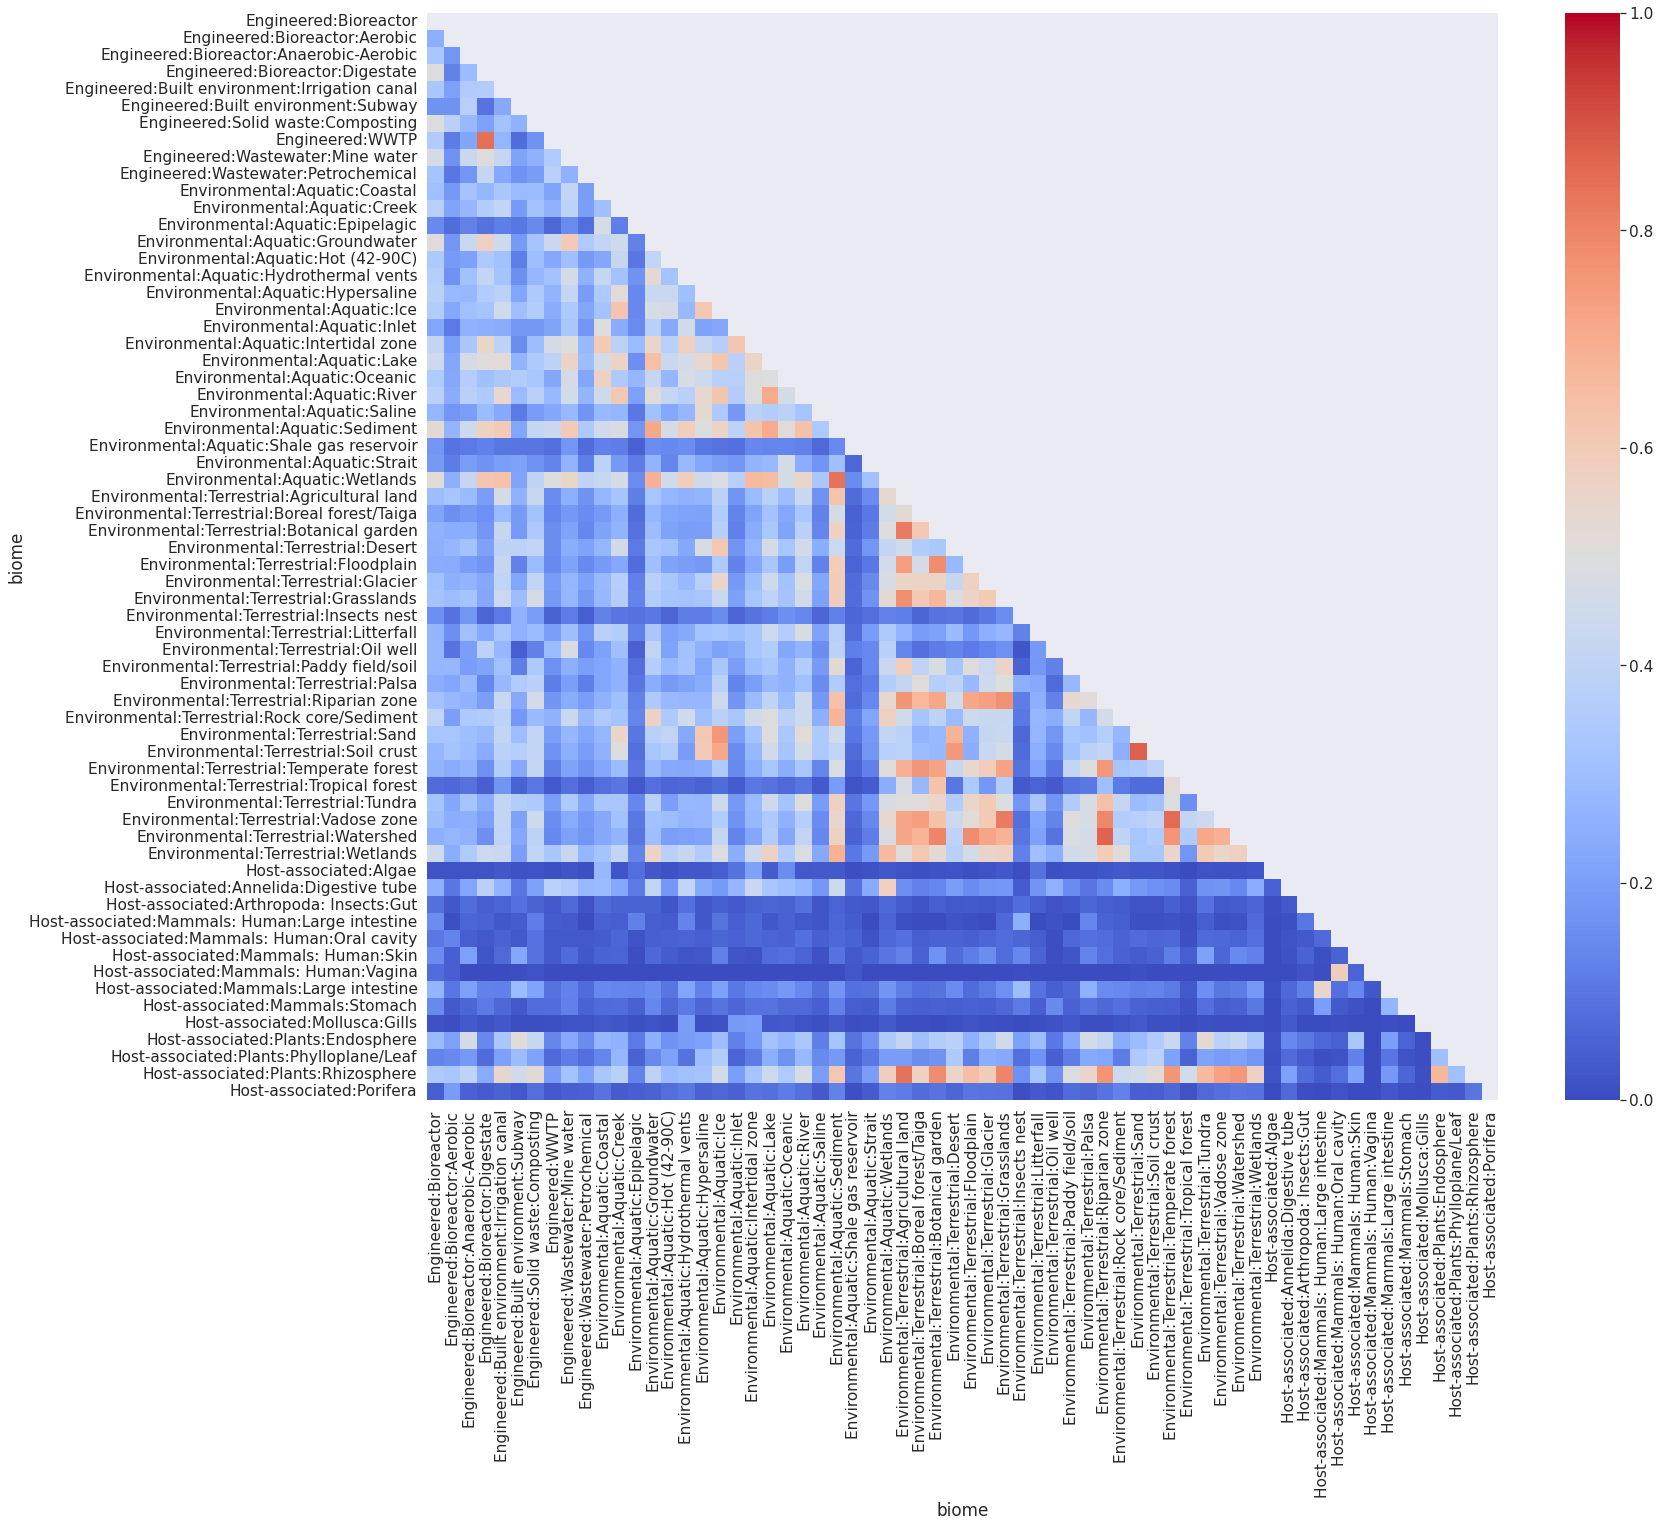

In [81]:
# plot heatmap
plt.figure(figsize=(24,20))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(g_grouped_transposed.corr(), dtype=bool))
#sns.set(font_scale=1.4)
# generate heatmap
sns.heatmap(g_grouped_transposed.corr(), annot=False, mask=mask, vmin=0, vmax=1, cmap="coolwarm")
plt.show()

In [69]:
c = g_grouped_transposed.corr()
s = c.unstack()
so = pd.DataFrame(s.sort_values(kind="quicksort", ascending=False))
so.columns = ['corr']
so.index = so.index.set_names(['foo','boo'])
so = so.reset_index()
so = so[so['corr']<1]

,foo,boo,corr
64,Environmental:Terrestrial:Sand,Environmental:Terrestrial:Soil crust,0.871640
65,Environmental:Terrestrial:Soil crust,Environmental:Terrestrial:Sand,0.871640
66,Environmental:Terrestrial:Watershed,Environmental:Terrestrial:Riparian zone,0.870659
67,Environmental:Terrestrial:Riparian zone,Environmental:Terrestrial:Watershed,0.870659
68,Environmental:Terrestrial:Temperate forest,Environmental:Terrestrial:Vadose zone,0.852448
...,...,...,...
4091,Environmental:Terrestrial:Botanical garden,Host-associated:Mammals: Human:Large intestine,-0.002434
4092,Host-associated:Mammals: Human:Large intestine,Environmental:Terrestrial:Litterfall,-0.005170
4093,Environmental:Terrestrial:Litterfall,Host-associated:Mammals: Human:Large intestine,-0.005170
4094,Host-associated:Mammals: Human:Large intestine,Engineered:Wastewater:Petrochemical,-0.009033


In [77]:
so[0:50]

,foo,boo,corr
64,Environmental:Terrestrial:Sand,Environmental:Terrestrial:Soil crust,0.871640
65,Environmental:Terrestrial:Soil crust,Environmental:Terrestrial:Sand,0.871640
66,Environmental:Terrestrial:Watershed,Environmental:Terrestrial:Riparian zone,0.870659
67,Environmental:Terrestrial:Riparian zone,Environmental:Terrestrial:Watershed,0.870659
68,Environmental:Terrestrial:Temperate forest,Environmental:Terrestrial:Vadose zone,0.852448
69,Environmental:Terrestrial:Vadose zone,Environmental:Terrestrial:Temperate forest,0.852448
70,Engineered:Bioreactor:Digestate,Engineered:WWTP,0.841116
71,Engineered:WWTP,Engineered:Bioreactor:Digestate,0.841116
72,Environmental:Aquatic:Wetlands,Environmental:Aquatic:Sediment,0.839581
73,Environmental:Aquatic:Sediment,Environmental:Aquatic:Wetlands,0.839581


## Disease correlations

In [85]:
g, le = read_in_data_filter_integer_labels(grouped=30)

74
(16121, 14992)
constant columns:  []
(16121, 14992)


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [86]:
g = g[g.biome=='Host-associated:Mammals: Human:Large intestine']

In [87]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD

/tmp/ipykernel_30630/647518311.py:1: DtypeWarning: Columns (15,17,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")


In [88]:
concat = g.merge(h[['GOLD Analysis Project ID', 'Disease']], on='GOLD Analysis Project ID', how='left')
concat = concat.drop(['biome','GOLD Analysis Project ID'],axis=1)
concat['biome'] = concat.Disease
concat = concat.drop(['Disease'],axis=1)
concat

,860.0,2075.0,2135.0,4618.0,4629.0,4818.0,5263.0,5531.0,5657.0,9740.0,...,112326.0,97924.0,97784.0,14439.0,21995.0,33206.0,32137.0,86278.0,103472.0,biome
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Newborn
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Newborn
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Newborn
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [97]:
concat = concat.loc[:,~(concat.sum(axis=0) == 0)]

In [98]:
concat_grouped = concat.groupby('biome').mean()
concat_grouped = concat_grouped.T
concat_grouped

biome,Adenoma,Cancer,Dysbiosis in Rheumatoid Arthritis,ETEC H10407 challenge study.,Hadza hunter-gatherer gut microbiota.,Liver cirrhosis,Newborn,Normal,Type 2 Diabetes,V. cholera challenge study.,microbial dysbiosis in young adults with obesity,obese patients following a weight-loss intervention,symptomatic atherosclerosis,ulcerative colitis fecal transplant
860.0,0.0,0.0,7.193348e-07,0.000000,0.000000,0.000000,0.000015,9.921111e-07,0.000000,0.000000,0.000005,0.000001,0.000000,0.000000
2075.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.102732e-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5263.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000006,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5657.0,0.0,0.0,0.000000e+00,0.000000,0.000016,0.000000,0.000000,0.000000e+00,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000
11054.0,0.0,0.0,4.118119e-05,0.000000,0.000000,0.000000,0.000000,3.442644e-06,0.000000,0.000000,0.000168,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104194.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.186872e-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3278.0,0.0,0.0,4.778951e-04,0.000150,0.000000,0.000216,0.000113,6.358972e-04,0.000837,0.000295,0.000644,0.000190,0.000120,0.000000
43444.0,0.0,0.0,9.986884e-05,0.000311,0.000000,0.000116,0.000013,1.579112e-04,0.000138,0.000124,0.000300,0.000521,0.000055,0.000000
55257.0,0.0,0.0,1.256433e-05,0.000058,0.000000,0.000052,0.000009,9.445400e-05,0.000037,0.000012,0.000026,0.000011,0.000000,0.000000


In [106]:
# calculate spearman's correlation
coef, p = spearmanr(concat_grouped['microbial dysbiosis in young adults with obesity'], 
                    concat_grouped['Type 2 Diabetes'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.916
Samples are correlated (reject H0) p=0.000


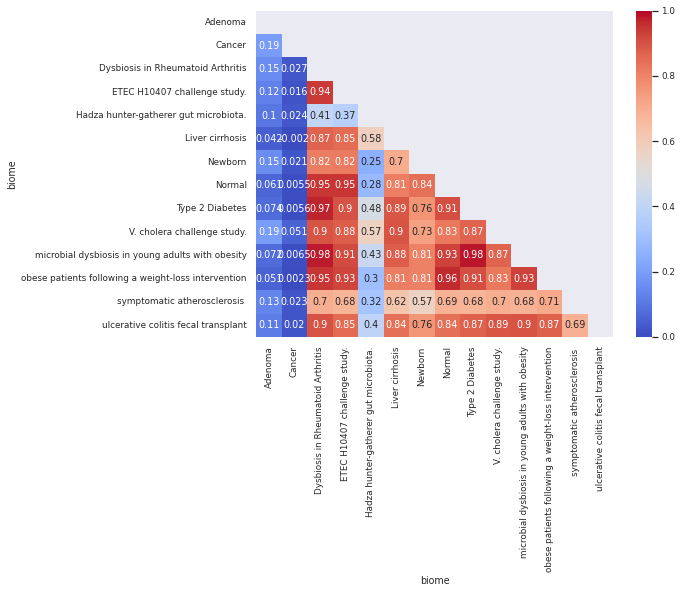

In [108]:
# plot heatmap
plt.figure(figsize=(8,6))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(concat_grouped.corr(), dtype=bool))
sns.set(font_scale=0.8)
# generate heatmap
sns.heatmap(concat_grouped.corr(), annot=True, mask=mask, vmin=0, vmax=1, cmap="coolwarm")
plt.show()